In [ ]:


import numpy as np
import pandas as pd

import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from copy import deepcopy

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Project'

/content/drive/MyDrive/Project


In [ ]:
df = pd.read_csv('diabetes.csv')
df.head(14)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [ ]:
print('Number of records: ', len(df))

Number of records:  768


In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
data = df.copy()

In [ ]:
def feature_median(feature, target):
    # make a data frame of the given feature and Outcome
    raw = data[[feature, 'Outcome']]
    # get rows where Outcome = (given target) and (given feature) != 0
    filtered = raw.loc[(raw['Outcome'] == target) & (raw[feature] != 0)]
    return filtered[feature].median()

In [ ]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'] == 0), 'Insulin'] = feature_median('Insulin', 0)
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'] == 0), 'Insulin'] = feature_median('Insulin', 1)

data.loc[(data['Outcome'] == 0 ) & (data['Glucose'] == 0), 'Glucose'] = feature_median('Glucose', 0)
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'] == 0), 'Glucose'] = feature_median('Glucose', 1)

data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'] == 0), 'SkinThickness'] = feature_median('SkinThickness', 0)
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'] == 0), 'SkinThickness'] = feature_median('SkinThickness', 1)

data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'] == 0), 'BloodPressure'] = feature_median('BloodPressure', 0)
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'] == 0), 'BloodPressure'] = feature_median('BloodPressure', 1)

data.loc[(data['Outcome'] == 0 ) & (data['BMI'] == 0), 'BMI'] = feature_median('BMI', 0)
data.loc[(data['Outcome'] == 1 ) & (data['BMI'] == 0), 'BMI'] = feature_median('BMI', 1)


data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']


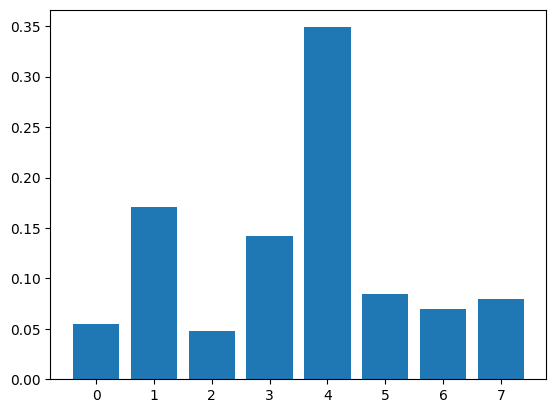

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=250)
clf.fit(X_train, y_train)
importance = clf.feature_importances_

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35,169.5,33.6,0.627,50,1
1,1,85,66.0,29,102.5,26.6,0.351,31,0
2,8,183,64.0,32,169.5,23.3,0.672,32,1
3,1,89,66.0,23,94.0,28.1,0.167,21,0
4,0,137,40.0,35,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76.0,48,180.0,32.9,0.171,63,0
764,2,122,70.0,27,102.5,36.8,0.340,27,0
765,5,121,72.0,23,112.0,26.2,0.245,30,0
766,1,126,60.0,32,169.5,30.1,0.349,47,1


In [ ]:
X = X[['Glucose','BMI','Age','Insulin']]
X

,Glucose,BMI,Age,Insulin
0,148,33.6,50,169.5
1,85,26.6,31,102.5
2,183,23.3,32,169.5
3,89,28.1,21,94.0
4,137,43.1,33,168.0
...,...,...,...,...
763,101,32.9,63,180.0
764,122,36.8,27,102.5
765,121,26.2,30,112.0
766,126,30.1,47,169.5


In [ ]:
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [ ]:
y.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=40,stratify=y)

In [ ]:
RANDOM_FOREST = 'Random Forest Classifier'
XGBOOST = 'XGBClassifier'
GRADIENT_BOOSTING = 'Gradient Boosting Classifier'
K_NEIGHBORS_CLASSIFIER = 'KNeighbors Classifier'
LOGISTIC_REGRESSION = 'Logistic Regression'

classifiers = {
    RANDOM_FOREST: RandomForestClassifier(),
    XGBOOST: XGBClassifier(),
    GRADIENT_BOOSTING: GradientBoostingClassifier(),
    K_NEIGHBORS_CLASSIFIER: KNeighborsClassifier(),
    LOGISTIC_REGRESSION: LogisticRegression()
}

hyperparameters_grid = {
    RANDOM_FOREST: {
        "n_estimators": [150],
        "criterion": [ "entropy"],
        "max_depth": [ 30],
        "min_samples_leaf": [ 10],
    },

    XGBOOST: {
        "min_child_weight": [ 5],
        "gamma": [ 5],
        "max_depth": [7],
        "n_estimators": [ 150],
        "learning_rate": [0.05, 0.15],
    },

    GRADIENT_BOOSTING: {
        "n_estimators": [ 150],
        "max_depth": [ 7],
        "learning_rate": [ 1],
    },

    K_NEIGHBORS_CLASSIFIER: {
        "n_neighbors": [ 12],
        "weights": [ "distance"],
        "metric": [ "manhattan"],
    },

    LOGISTIC_REGRESSION: {
        "penalty": [ "l2"],
        "C": [ 0.01],
        "solver": [ "liblinear"],
    },
}

In [ ]:
def configure_hyperparameters_name(hyperparameters_grid):
    for model_name, hyperparameters in hyperparameters_grid.items():
        prefix = model_name.replace(' ', '').lower() # remove any white space and make it lower case

        # casting hyperparameters.items() to list to make a copy
        # because we can't modify a dictionary keys while iterating over it
        for param_name, _ in list(hyperparameters.items()):
            new_name = prefix + '__' + param_name
            # remove parameter with the old name then assign its value to the new name
            hyperparameters[new_name] = hyperparameters.pop(param_name)

In [ ]:
def tune_piplines(piplines, hyperparameters_grid):
    tuned_piplines = {}
    for name, pipline in piplines:
        hyperparameters = hyperparameters_grid[name]
        sk = StratifiedKFold(n_splits=5)
        grid_serach = GridSearchCV(pipline, hyperparameters, cv=sk, n_jobs=-1)
        grid_serach.fit(X_train, y_train)

        tuned_piplines[name] = grid_serach.best_estimator_

        print(name, ':')
        print(f'Tuned hpyerparameters : {grid_serach.best_params_}')
        print(f'Cross validation : {grid_serach.best_score_ * 100:.1f}%')
        print('\n\n')
    return tuned_piplines

In [ ]:
def fit_models(X_train, y_train, models, hyperparameters_grid, preprocessing=[]):
    print('-' * 20)
    print(preprocessing)
    print('-' * 20)

    hyperparameters_grid = deepcopy(hyperparameters_grid)

    # generate piplines
    piplines = []
    for name, model in models.items():
        pipline = make_pipeline(*preprocessing, model)
        piplines.append((name, pipline))


    configure_hyperparameters_name(hyperparameters_grid)

    return tune_piplines(piplines, hyperparameters_grid)

In [ ]:
def info(names):
    cls = {}
    params = {}
    for name in names:
        cls[name] = classifiers[name]
        params[name] = hyperparameters_grid[name]
    return cls, params

In [ ]:
noprep_models = fit_models(X_train, y_train, *info([RANDOM_FOREST, GRADIENT_BOOSTING, XGBOOST]))
standard_models = fit_models(X_train, y_train, *info([K_NEIGHBORS_CLASSIFIER, LOGISTIC_REGRESSION]), [StandardScaler()])
minmax_models = fit_models(X_train, y_train, *info([K_NEIGHBORS_CLASSIFIER, LOGISTIC_REGRESSION]), [MinMaxScaler()])

--------------------
[]
--------------------
Random Forest Classifier :
Tuned hpyerparameters : {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__n_estimators': 150}
Cross validation : 87.7%



Gradient Boosting Classifier :
Tuned hpyerparameters : {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__max_depth': 7, 'gradientboostingclassifier__n_estimators': 150}
Cross validation : 89.8%



XGBClassifier :
Tuned hpyerparameters : {'xgbclassifier__gamma': 5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 7, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 150}
Cross validation : 87.5%



--------------------
[StandardScaler()]
--------------------
KNeighbors Classifier :
Tuned hpyerparameters : {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__weights': 

In [ ]:
def evaluate(pred):
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        pred,
        display_labels=["Healthy", "Sick"],
        ax=ax,
        colorbar=False
    )

    plt.show()
    print(classification_report(y_test, pred))

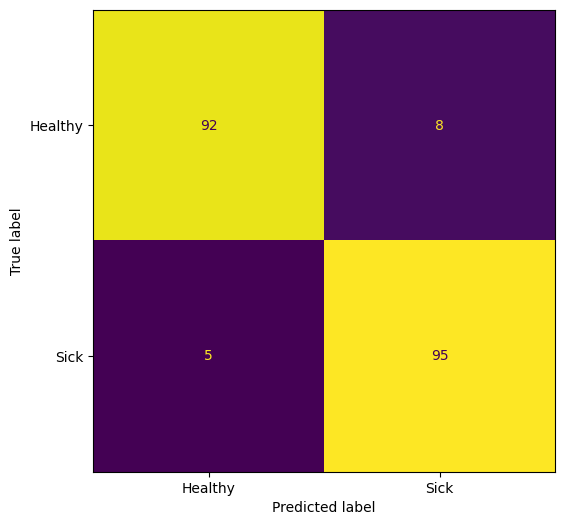

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       100
           1       0.92      0.95      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.93       200



In [ ]:
rfc = noprep_models[RANDOM_FOREST]
rfc_pred = rfc.predict(X_test)
evaluate(rfc_pred)

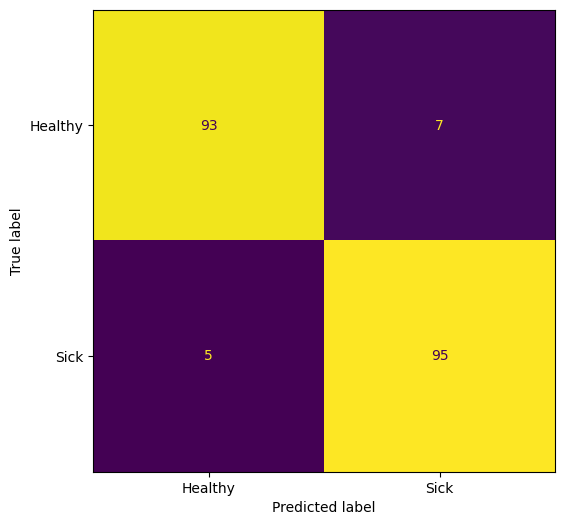

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       100
           1       0.93      0.95      0.94       100

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



In [ ]:
xgb = noprep_models[XGBOOST]
xgb_pred = xgb.predict(X_test)
evaluate(xgb_pred)

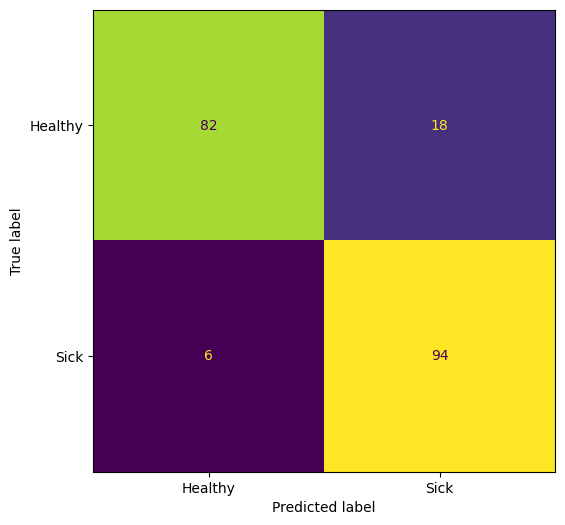

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       100
           1       0.84      0.94      0.89       100

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



In [ ]:
knn = standard_models[K_NEIGHBORS_CLASSIFIER]
knn_pred = knn.predict(X_test)
evaluate(knn_pred)

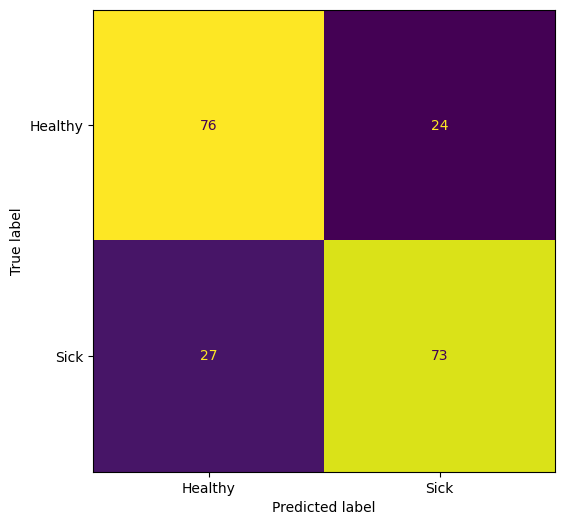

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       100
           1       0.75      0.73      0.74       100

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



In [ ]:
l_r = standard_models[LOGISTIC_REGRESSION]
lr_pred = l_r.predict(X_test)
evaluate(lr_pred)

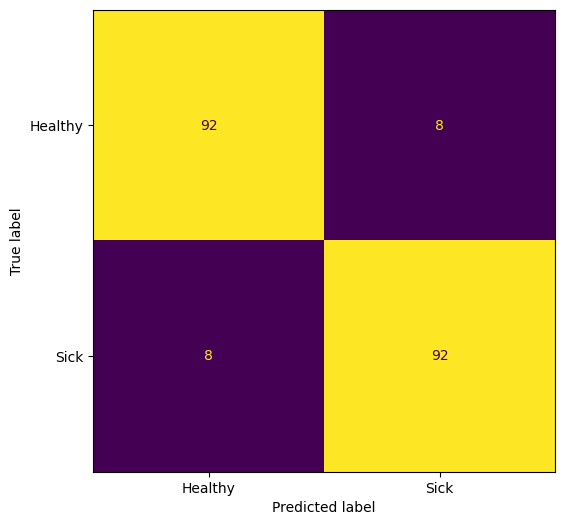

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       100
           1       0.92      0.92      0.92       100

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [ ]:
gr = noprep_models[GRADIENT_BOOSTING]
gr_pred = gr.predict(X_test)
evaluate(gr_pred)